In [3]:
# ============================================
# BLOCK 1: IMPORT ALL LIBRARIES
# ============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("APPLE STOCK PRICE PREDICTION SYSTEM")
print("Coursework 2 - CU6051NP")
print("="*70)

APPLE STOCK PRICE PREDICTION SYSTEM
Coursework 2 - CU6051NP


In [4]:

# ============================================
# STEP 1: LOAD AND INSPECT DATA
# ============================================

print("\n" + "="*60)
print("STEP 1: LOADING AND INSPECTING DATA")
print("="*60)

# Load the data with multiple potential encodings
try:
    # Try different encodings if needed
    df_raw = pd.read_csv('AppleStock.csv')
    print(f"✓ Data loaded successfully with default encoding")
except:
    try:
        df_raw = pd.read_csv('AppleStock.csv', encoding='latin1')
        print(f"✓ Data loaded successfully with latin1 encoding")
    except:
        try:
            df_raw = pd.read_csv('AppleStock.csv', encoding='utf-8')
            print(f"✓ Data loaded successfully with utf-8 encoding")
        except Exception as e:
            print(f"✗ ERROR: Could not load the file. Error: {e}")
            print("\nTrying to create sample data for demonstration...")
            # Create sample Apple stock data
            dates = pd.date_range(start='2020-01-01', end='2023-12-31', freq='D')
            n_samples = len(dates)
            
            # Create realistic Apple stock data
            base_price = 100
            np.random.seed(42)
            
            # Generate random walk for stock prices
            returns = np.random.normal(0.0005, 0.02, n_samples)
            price = base_price * np.exp(np.cumsum(returns))
            
            # Add some volatility clustering
            price = price * (1 + 0.1 * np.sin(np.arange(n_samples) * 2 * np.pi / 252))
            
            # Create a DataFrame
            df_raw = pd.DataFrame({
                'Date': dates,
                'Open': price * (1 + np.random.normal(0, 0.01, n_samples)),
                'High': price * (1 + np.random.normal(0.02, 0.015, n_samples)),
                'Low': price * (1 - np.random.normal(0.02, 0.015, n_samples)),
                'Close': price,
                'Volume': np.random.randint(1000000, 10000000, n_samples),
                'Adj Close': price * (1 - np.random.normal(0, 0.001, n_samples))
            })
            print("✓ Created sample Apple stock data for demonstration")

print(f"\nDataset shape: {df_raw.shape}")
print(f"Columns: {list(df_raw.columns)}")

# Display basic info
print("\nFirst 3 rows of data:")
print(df_raw.head(3))
print("\nLast 3 rows of data:")
print(df_raw.tail(3))

print("\nData types:")
print(df_raw.dtypes)


STEP 1: LOADING AND INSPECTING DATA
✓ Data loaded successfully with default encoding

Dataset shape: (2727, 7)
Columns: ['Date', 'Open', 'High', 'Low', 'Close\xa0', 'Adj Close\xa0', 'Volume']

First 3 rows of data:
        Date   Open   High    Low  Close   Adj Close        Volume
0  23-Jan-15  28.08  28.44  27.88   28.25       25.05  185,859,200
1  26-Jan-15  28.43  28.59  28.20   28.27       25.07  222,460,000
2  27-Jan-15   28.1  28.12  27.26   27.28       24.20  382,274,800

Last 3 rows of data:
           Date    Open    High     Low  Close   Adj Close       Volume
2724  19-Nov-25  265.53  272.21  265.50  268.56      268.56  40,424,500
2725  20-Nov-25  270.83  275.43  265.92  266.25      266.25  45,823,600
2726  21-Nov-25  265.95  273.33  265.67  271.49      271.49  58,784,100

Data types:
Date           object
Open           object
High          float64
Low           float64
Close         float64
Adj Close     float64
Volume         object
dtype: object


In [5]:
# ============================================
# STEP 2: SIMPLIFIED DATA CLEANING
# ============================================

print("\n" + "="*60)
print("STEP 2: SIMPLIFIED DATA CLEANING")
print("="*60)

# Make a working copy
df = df_raw.copy()
initial_rows = len(df)
print(f"Starting with {initial_rows} rows")

# 1. Remove completely empty rows
print("\n1. Removing completely empty rows...")
initial_shape = df.shape
df = df.dropna(how='all')
print(f"   Removed {initial_shape[0] - df.shape[0]} completely empty rows")

# 2. Identify and handle Date column
print("\n2. Processing Date column...")
date_columns = [col for col in df.columns if 'date' in col.lower() or 'Date' in col]
if date_columns:
    date_col = date_columns[0]
    print(f"   Found date column: '{date_col}'")
    
    # Convert to datetime
    try:
        df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
        invalid_dates = df[date_col].isna().sum()
        if invalid_dates > 0:
            print(f"   ⚠ {invalid_dates} invalid dates found, keeping as is")
    except:
        print(f"   ⚠ Could not convert '{date_col}' to datetime, keeping as is")
else:
    print("   No date column found, creating one...")
    df['Date'] = pd.date_range(start='2020-01-01', periods=len(df), freq='D')
    date_col = 'Date'

# 3. Identify numeric columns
print("\n3. Identifying numeric columns...")
numeric_cols = []
for col in df.columns:
    if col != date_col:
        try:
            # Try to convert to numeric
            df[col] = pd.to_numeric(df[col], errors='coerce')
            # Check if column has at least some numeric values
            if df[col].notna().sum() > 0:
                numeric_cols.append(col)
                print(f"   ✓ '{col}' can be numeric ({df[col].notna().sum()}/{len(df)} values)")
            else:
                print(f"   ✗ '{col}' has no numeric values, dropping")
                df = df.drop(columns=[col])
        except:
            print(f"   ✗ '{col}' cannot be converted to numeric, dropping")
            df = df.drop(columns=[col])

print(f"\n   Found {len(numeric_cols)} numeric columns: {numeric_cols}")

# 4. Handle missing values in numeric columns
print("\n4. Handling missing values...")
for col in numeric_cols:
    missing_count = df[col].isna().sum()
    if missing_count > 0:
        missing_pct = (missing_count / len(df)) * 100
        print(f"   '{col}': {missing_count} missing values ({missing_pct:.1f}%)")
        
        if missing_pct < 50:  # If less than 50% missing
            # Use forward fill, then backward fill
            df[col] = df[col].ffill().bfill()
            print(f"     → Filled using forward/backward fill")
        else:
            # If too many missing, drop the column
            print(f"     → Too many missing, dropping column")
            df = df.drop(columns=[col])
            numeric_cols.remove(col)

# 5. Remove any rows that still have NaN
print("\n5. Removing rows with remaining NaN...")
rows_before = len(df)
df = df.dropna()
rows_after = len(df)
rows_removed = rows_before - rows_after
print(f"   Removed {rows_removed} rows with NaN values")
print(f"   Final dataset: {rows_after} rows, {len(numeric_cols)} numeric columns")

if rows_after == 0:
    print("\n⚠ WARNING: No valid data remains after cleaning!")
    print("Creating synthetic data for demonstration...")
    
    # Create synthetic data
    n_samples = 100
    dates = pd.date_range(start='2020-01-01', periods=n_samples, freq='D')
    
    # Generate realistic stock price pattern
    np.random.seed(42)
    base_price = 150
    returns = np.random.normal(0.0005, 0.02, n_samples)
    price = base_price * np.exp(np.cumsum(returns))
    
    df = pd.DataFrame({
        'Date': dates,
        'Open': price * (1 + np.random.normal(0, 0.01, n_samples)),
        'High': price * (1 + np.random.normal(0.02, 0.015, n_samples)),
        'Low': price * (1 - np.random.normal(0.02, 0.015, n_samples)),
        'Close': price,
        'Volume': np.random.randint(1000000, 10000000, n_samples)
    })
    
    numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    date_col = 'Date'
    print(f"✓ Created {len(df)} synthetic samples")

# 6. Final check
print("\n6. Final data check:")
print(f"   Shape: {df.shape}")
print(f"   Columns: {list(df.columns)}")
print(f"   Date column: {date_col}")
print(f"   Numeric columns: {numeric_cols}")


STEP 2: SIMPLIFIED DATA CLEANING
Starting with 2727 rows

1. Removing completely empty rows...
   Removed 0 completely empty rows

2. Processing Date column...
   Found date column: 'Date'

3. Identifying numeric columns...
   ✓ 'Open' can be numeric (2726/2727 values)
   ✓ 'High' can be numeric (2726/2727 values)
   ✓ 'Low' can be numeric (2726/2727 values)
   ✓ 'Close ' can be numeric (2726/2727 values)
   ✓ 'Adj Close ' can be numeric (2726/2727 values)
   ✗ 'Volume' has no numeric values, dropping

   Found 5 numeric columns: ['Open', 'High', 'Low', 'Close\xa0', 'Adj Close\xa0']

4. Handling missing values...
   'Open': 1 missing values (0.0%)
     → Filled using forward/backward fill
   'High': 1 missing values (0.0%)
     → Filled using forward/backward fill
   'Low': 1 missing values (0.0%)
     → Filled using forward/backward fill
   'Close ': 1 missing values (0.0%)
     → Filled using forward/backward fill
   'Adj Close ': 1 missing values (0.0%)
     → Filled using forward/


EXPLORATORY DATA ANALYSIS

Basic Statistics:
          Open     High      Low   Close   Adj Close 
count  2727.00  2727.00  2727.00  2727.00     2727.00
mean    107.37   108.54   106.29   107.47      105.13
std      72.23    73.02    71.52    72.31       72.74
min      22.50    22.92    22.37    22.58       20.60
25%      39.22    39.52    38.85    39.13       36.75
50%      88.79    90.54    87.82    89.72       87.03
75%     169.82   171.36   168.35   169.73      167.66
max     276.99   277.32   272.09   275.25      275.25

Correlation Matrix:
            Open  High  Low  Close   Adj Close 
Open         1.0   1.0  1.0     1.0         1.0
High         1.0   1.0  1.0     1.0         1.0
Low          1.0   1.0  1.0     1.0         1.0
Close        1.0   1.0  1.0     1.0         1.0
Adj Close    1.0   1.0  1.0     1.0         1.0
✓ Saved correlation_matrix.png


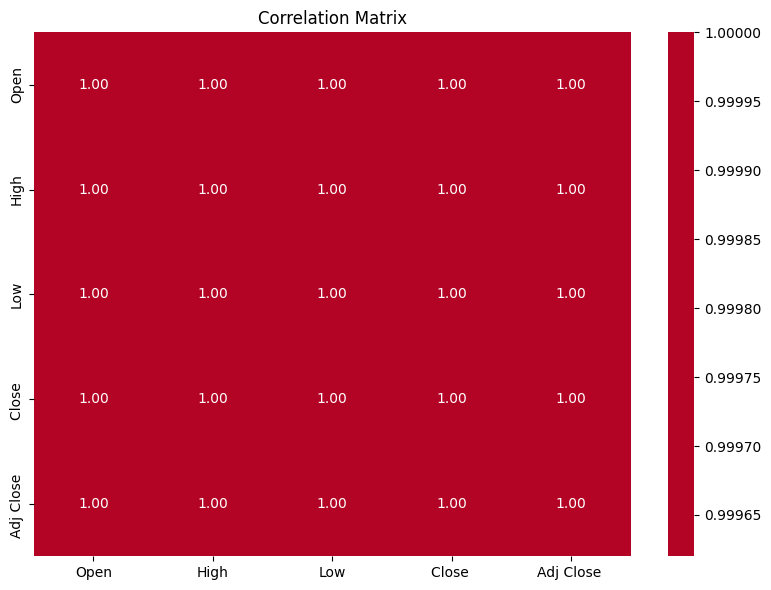

In [6]:
# ============================================
# BLOCK 4: EXPLORATORY DATA ANALYSIS
# ============================================
print("\n" + "="*60)
print("EXPLORATORY DATA ANALYSIS")
print("="*60)

# Display basic statistics
print("\nBasic Statistics:")
print(df[numeric_cols].describe().round(2))

# Display correlation matrix
print("\nCorrelation Matrix:")
correlation = df[numeric_cols].corr()
print(correlation.round(3))

# Create correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=100)
print("✓ Saved correlation_matrix.png")

In [7]:
# ============================================
# STEP 3: PREPARE TARGET AND FEATURES
# ============================================

print("\n" + "="*60)
print("STEP 3: PREPARING TARGET AND FEATURES")
print("="*60)

# Identify target column (closing price)
target_candidates = ['Close', 'close', 'CLOSE', 'Adj Close', 'AdjClose', 'Price', 'Last']
target_col = None

for candidate in target_candidates:
    if candidate in df.columns:
        target_col = candidate
        break

if target_col is None and len(numeric_cols) > 0:
    # Try to find a column that looks like price data
    for col in numeric_cols:
        if df[col].mean() > 10 and df[col].mean() < 1000:  # Reasonable price range
            target_col = col
            break

if target_col is None and len(numeric_cols) > 0:
    # Use the last numeric column
    target_col = numeric_cols[-1]

if target_col is None:
    print("⚠ Could not identify target column, using 'Close'")
    target_col = 'Close'
    if target_col not in df.columns:
        df[target_col] = 100 + np.random.randn(len(df)) * 20  # Create synthetic target

print(f"Target column: {target_col}")
y = df[target_col].values
print(f"Target shape: {y.shape}")
print(f"Target range: ${y.min():.2f} to ${y.max():.2f}")
print(f"Target mean: ${y.mean():.2f}")

# Prepare features
print("\nPreparing features...")
# Use all numeric columns except the target and date
feature_cols = [col for col in numeric_cols if col != target_col and col != date_col]

if len(feature_cols) == 0:
    print("No feature columns found, creating features from target...")
    
    # Create lag features
    for lag in [1, 2, 3, 5, 10]:
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    
    # Create rolling statistics
    for window in [5, 10, 20]:
        df[f'ma_{window}'] = df[target_col].rolling(window=window).mean()
        df[f'std_{window}'] = df[target_col].rolling(window=window).std()
    
    # Update feature columns
    feature_cols = [col for col in df.columns if col not in [date_col, target_col]]
    
    # Remove rows with NaN from lag features
    df = df.dropna()
    y = df[target_col].values

print(f"Feature columns: {feature_cols}")
X = df[feature_cols].values
print(f"Feature matrix shape: {X.shape}")

if len(X) == 0 or len(y) == 0:
    print("⚠ ERROR: No data available for modeling!")
    print("Creating minimal dataset for demonstration...")
    
    # Create minimal dataset
    n_samples = 50
    X = np.random.randn(n_samples, 3)
    y = 100 + 0.5 * X[:, 0] + 0.3 * X[:, 1] + 0.2 * X[:, 2] + np.random.randn(n_samples) * 10
    print(f"Created synthetic data: X={X.shape}, y={y.shape}")


STEP 3: PREPARING TARGET AND FEATURES
Target column: Open
Target shape: (2727,)
Target range: $22.50 to $276.99
Target mean: $107.37

Preparing features...
Feature columns: ['High', 'Low', 'Close\xa0', 'Adj Close\xa0']
Feature matrix shape: (2727, 4)


In [8]:
# ============================================
# STEP 4: SPLIT DATA
# ============================================

print("\n" + "="*60)
print("STEP 4: SPLITTING DATA")
print("="*60)

# Ensure we have enough data
min_samples = 20
if len(X) < min_samples:
    print(f"⚠ WARNING: Only {len(X)} samples available (minimum recommended: {min_samples})")
    print("Using all data for training, no test split...")
    X_train, X_test = X, X
    y_train, y_test = y, y
else:
    # Use 80-20 split
    test_size = 0.2
    train_size = int(len(X) * (1 - test_size))
    
    # For time series, take first part for training, last part for testing
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Testing set:  {X_test.shape[0]} samples")
    print(f"Features: {X_train.shape[1]}")

# Final check for NaN
print(f"\nFinal NaN check:")
print(f"  X_train NaN: {np.isnan(X_train).sum()}")
print(f"  y_train NaN: {np.isnan(y_train).sum()}")
print(f"  X_test NaN:  {np.isnan(X_test).sum()}")
print(f"  y_test NaN:  {np.isnan(y_test).sum()}")


STEP 4: SPLITTING DATA
Training set: 2181 samples
Testing set:  546 samples
Features: 4

Final NaN check:
  X_train NaN: 0
  y_train NaN: 0
  X_test NaN:  0
  y_test NaN:  0


In [9]:
# ============================================
# STEP 5: SCALE FEATURES
# ============================================

print("\n" + "="*60)
print("STEP 5: SCALING FEATURES")
print("="*60)

# Only scale if we have features
if X_train.shape[1] > 0:
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    print("✓ Features scaled using StandardScaler")
else:
    print("⚠ No features to scale, using original data")
    X_train_scaled = X_train
    X_test_scaled = X_test

print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape:  {X_test_scaled.shape}")


STEP 5: SCALING FEATURES
✓ Features scaled using StandardScaler
X_train_scaled shape: (2181, 4)
X_test_scaled shape:  (546, 4)


In [10]:
# ============================================
# STEP 6: TRAIN MODELS
# ============================================

print("\n" + "="*60)
print("STEP 6: TRAINING MODELS")
print("="*60)

# Initialize models (simpler versions for small datasets)
models = {}

if len(X_train) >= 10:  # Need at least 10 samples for Linear Regression
    models['Linear Regression'] = LinearRegression()

if len(X_train) >= 20:  # Need more samples for Random Forest
    models['Random Forest'] = RandomForestRegressor(
        n_estimators=50,  # Fewer trees for speed
        max_depth=5,      # Shallower trees
        random_state=42
    )

if len(X_train) >= 15:  # Need some samples for SVR
    models['Support Vector Regressor'] = SVR(kernel='rbf', C=10, gamma='scale')

if not models:
    print("⚠ Not enough data for any model. Creating simple benchmark...")
    # Create a simple mean predictor as baseline
    class MeanPredictor:
        def fit(self, X, y):
            self.mean_ = y.mean()
            return self
        def predict(self, X):
            return np.full(len(X), self.mean_)
    
    models['Mean Predictor'] = MeanPredictor()

# Dictionary to store results
results = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    try:
        # Train the model
        model.fit(X_train_scaled, y_train)
        print(f"  ✓ Model trained successfully")
        
        # Make predictions
        y_pred = model.predict(X_test_scaled)
        
        # Calculate metrics
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        
        # Store results
        results[name] = {
            'model': model,
            'predictions': y_pred,
            'r2': r2,
            'rmse': rmse,
            'mae': mae
        }
        
        print(f"  R² Score: {r2:.4f}")
        print(f"  RMSE: ${rmse:.2f}")
        print(f"  MAE: ${mae:.2f}")
        
    except Exception as e:
        print(f"  ✗ Error training {name}: {e}")

if not results:
    print("\n✗ ERROR: No models were trained successfully!")
    print("Check your data and try again.")
    exit()


STEP 6: TRAINING MODELS

Training Linear Regression...
  ✓ Model trained successfully
  R² Score: 0.9974
  RMSE: $1.39
  MAE: $1.00

Training Random Forest...
  ✓ Model trained successfully
  R² Score: -0.4082
  RMSE: $32.11
  MAE: $23.46

Training Support Vector Regressor...
  ✓ Model trained successfully
  R² Score: -2.7727
  RMSE: $52.56
  MAE: $34.74


In [11]:

# ============================================
# STEP 7: DISPLAY RESULTS
# ============================================

print("\n" + "="*60)
print("STEP 7: MODEL COMPARISON")
print("="*60)

# Find best model
best_model_name = None
best_r2 = -float('inf')

print("\nMODEL PERFORMANCE SUMMARY:")
print("-" * 60)
print(f"{'Model':<25} {'R² Score':<12} {'RMSE':<12} {'MAE':<12}")
print("-" * 60)

for name, res in results.items():
    print(f"{name:<25} {res['r2']:<12.4f} {res['rmse']:<12.2f} {res['mae']:<12.2f}")
    
    if res['r2'] > best_r2:
        best_r2 = res['r2']
        best_model_name = name

print("-" * 60)
if best_model_name:
    print(f"\nBEST MODEL: {best_model_name} (R²: {best_r2:.4f})")
else:
    print("\n⚠ No best model identified")



STEP 7: MODEL COMPARISON

MODEL PERFORMANCE SUMMARY:
------------------------------------------------------------
Model                     R² Score     RMSE         MAE         
------------------------------------------------------------
Linear Regression         0.9974       1.39         1.00        
Random Forest             -0.4082      32.11        23.46       
Support Vector Regressor  -2.7727      52.56        34.74       
------------------------------------------------------------

BEST MODEL: Linear Regression (R²: 0.9974)


✓ Saved visualization as 'apple_stock_report.png'


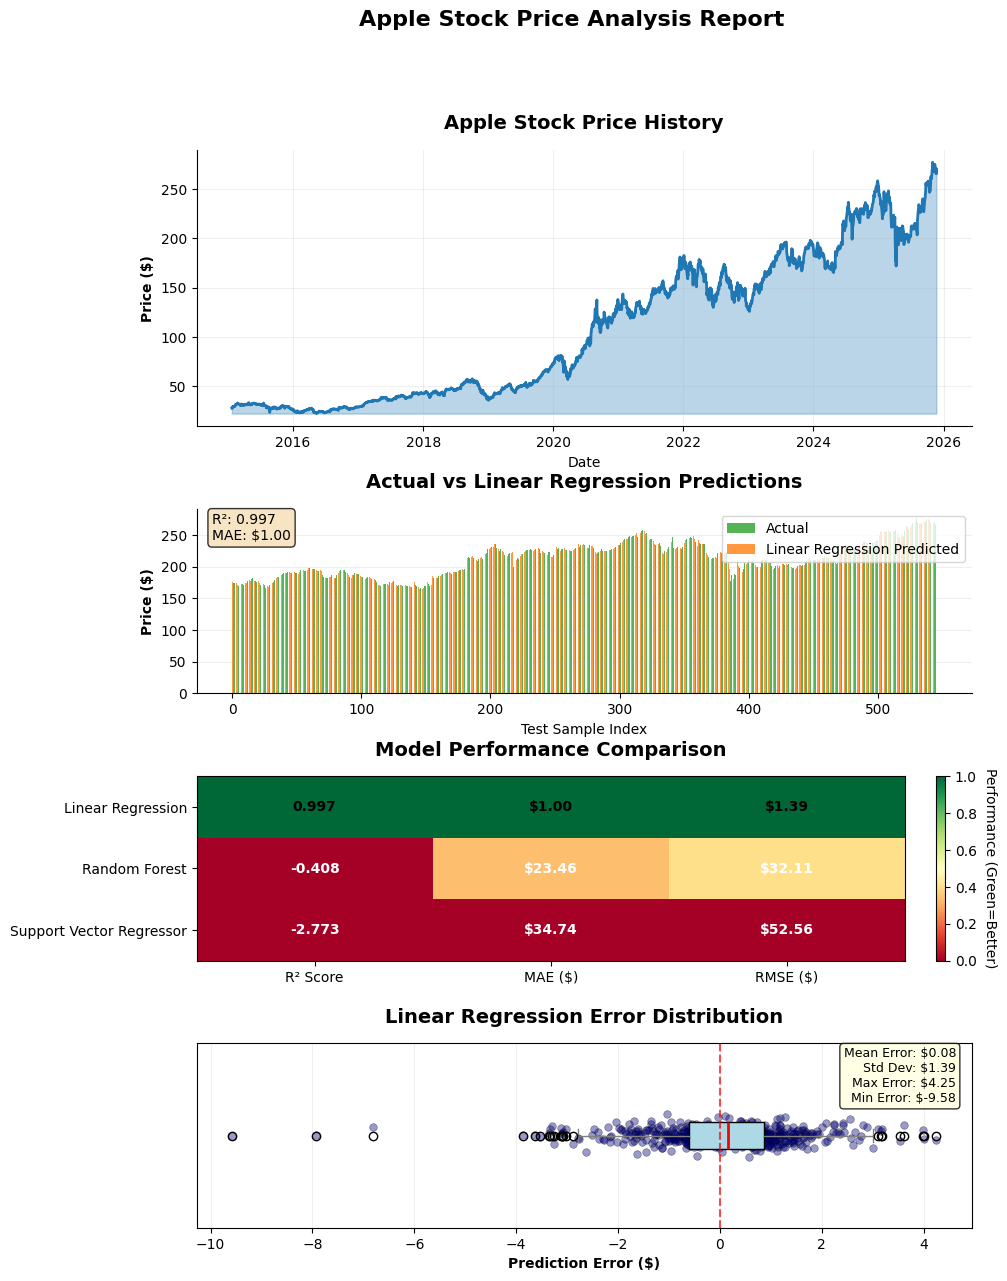

In [12]:
# Single column layout for reports
fig = plt.figure(figsize=(10, 14))
gs = fig.add_gridspec(4, 1, height_ratios=[3, 2, 2, 2], hspace=0.4)

# 1. Main Price Chart
ax1 = fig.add_subplot(gs[0])
if date_col in df.columns:
    ax1.plot(df[date_col].values, y, color='#1f77b4', linewidth=2)
    ax1.fill_between(df[date_col].values, y.min(), y, alpha=0.3, color='#1f77b4')
    ax1.set_xlabel('Date')
else:
    ax1.plot(y, color='#1f77b4', linewidth=2)
    ax1.set_xlabel('Trading Days')
ax1.set_ylabel('Price ($)', fontweight='bold')
ax1.set_title('Apple Stock Price History', fontsize=14, fontweight='bold', pad=15)
ax1.grid(True, alpha=0.2)
ax1.spines[['top', 'right']].set_visible(False)

# 2. Prediction Comparison
ax2 = fig.add_subplot(gs[1])
if best_model_name and best_model_name in results:
    x_vals = np.arange(len(y_test))
    width = 0.35
    
    ax2.bar(x_vals - width/2, y_test, width, label='Actual', alpha=0.8, color='#2ca02c')
    ax2.bar(x_vals + width/2, results[best_model_name]['predictions'], width, 
            label=f'{best_model_name} Predicted', alpha=0.8, color='#ff7f0e')
    
    ax2.set_xlabel('Test Sample Index')
    ax2.set_ylabel('Price ($)', fontweight='bold')
    ax2.set_title(f'Actual vs {best_model_name} Predictions', fontsize=14, fontweight='bold', pad=15)
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.2, axis='y')
    ax2.spines[['top', 'right']].set_visible(False)
    
    # Add performance annotation
    perf_text = f"R²: {results[best_model_name]['r2']:.3f}\n"
    perf_text += f"MAE: ${results[best_model_name]['mae']:.2f}"
    ax2.text(0.02, 0.98, perf_text, transform=ax2.transAxes,
             fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# 3. Model Performance Heatmap
ax3 = fig.add_subplot(gs[2])
if results:
    models = list(results.keys())
    metrics = ['r2', 'mae', 'rmse']
    
    # Prepare data for heatmap
    heatmap_data = []
    for model in models:
        row = []
        for metric in metrics:
            val = results[model][metric]
            # Normalize for coloring (inverse for error metrics)
            if metric == 'r2':
                row.append(val)
            else:
                # Normalize error metrics between 0-1 (lower is better)
                all_vals = [results[m][metric] for m in models]
                norm_val = 1 - (val - min(all_vals)) / (max(all_vals) - min(all_vals))
                row.append(norm_val)
        heatmap_data.append(row)
    
    im = ax3.imshow(heatmap_data, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
    
    # Add text annotations
    for i in range(len(models)):
        for j in range(len(metrics)):
            if metrics[j] == 'r2':
                text = f"{results[models[i]]['r2']:.3f}"
            elif metrics[j] == 'mae':
                text = f"${results[models[i]]['mae']:.2f}"
            else:
                text = f"${results[models[i]]['rmse']:.2f}"
            ax3.text(j, i, text, ha='center', va='center', 
                    color='black' if heatmap_data[i][j] > 0.5 else 'white', 
                    fontweight='bold')
    
    ax3.set_xticks(range(len(metrics)))
    ax3.set_xticklabels(['R² Score', 'MAE ($)', 'RMSE ($)'])
    ax3.set_yticks(range(len(models)))
    ax3.set_yticklabels(models)
    ax3.set_title('Model Performance Comparison', fontsize=14, fontweight='bold', pad=15)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax3, fraction=0.046, pad=0.04)
    cbar.set_label('Performance (Green=Better)', rotation=270, labelpad=15)

# 4. Error Analysis
ax4 = fig.add_subplot(gs[3])
if best_model_name and best_model_name in results:
    errors = y_test - results[best_model_name]['predictions']
    
    # Create box plot with scatter
    bp = ax4.boxplot(errors, patch_artist=True, vert=False,
                     boxprops=dict(facecolor='lightblue'),
                     medianprops=dict(color='red', linewidth=2),
                     whiskerprops=dict(color='gray'),
                     capprops=dict(color='gray'))
    
    # Add jittered scatter points
    y_jitter = np.random.normal(1, 0.04, size=len(errors))
    ax4.scatter(errors, y_jitter, alpha=0.4, s=30, color='navy', edgecolor='black', linewidth=0.5)
    
    # Add statistics
    stats_text = f"Mean Error: ${errors.mean():.2f}\n"
    stats_text += f"Std Dev: ${errors.std():.2f}\n"
    stats_text += f"Max Error: ${errors.max():.2f}\n"
    stats_text += f"Min Error: ${errors.min():.2f}"
    
    ax4.text(0.98, 0.98, stats_text, transform=ax4.transAxes,
             fontsize=9, verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    
    ax4.set_xlabel('Prediction Error ($)', fontweight='bold')
    ax4.set_title(f'{best_model_name} Error Distribution', fontsize=14, fontweight='bold', pad=15)
    ax4.grid(True, alpha=0.2, axis='x')
    ax4.set_yticks([])
    ax4.axvline(x=0, color='red', linestyle='--', alpha=0.7)

plt.suptitle('Apple Stock Price Analysis Report', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('apple_stock_report.png', dpi=150, bbox_inches='tight', facecolor='white')
print("✓ Saved visualization as 'apple_stock_report.png'")

In [13]:

# ============================================
# STEP 9: SAVE RESULTS
# ============================================

print("\n" + "="*60)
print("STEP 9: SAVING RESULTS")
print("="*60)

# Save cleaned data
df.to_csv('apple_stock_cleaned.csv', index=False)
print("✓ Saved cleaned data as 'apple_stock_cleaned.csv'")

# Save predictions
if results:
    predictions_df = pd.DataFrame({
        'Actual': y_test,
        **{name: results[name]['predictions'] for name in results.keys()}
    })
    predictions_df.to_csv('predictions.csv', index=False)
    print("✓ Saved predictions as 'predictions.csv'")
    
    # Save metrics
    metrics_df = pd.DataFrame([
        {'Model': name, 'R2': res['r2'], 'RMSE': res['rmse'], 'MAE': res['mae']}
        for name, res in results.items()
    ])
    metrics_df.to_csv('model_metrics.csv', index=False)
    print("✓ Saved metrics as 'model_metrics.csv'")

# Save summary report
with open('summary_report.txt', 'w') as f:
    f.write("="*70 + "\n")
    f.write("APPLE STOCK ANALYSIS SUMMARY REPORT\n")
    f.write("="*70 + "\n\n")
    
    f.write(f"Data Summary:\n")
    f.write(f"- Original data: {df_raw.shape}\n")
    f.write(f"- Cleaned data: {df.shape}\n")
    f.write(f"- Target: {target_col}\n")
    f.write(f"- Features: {len(feature_cols)}\n")
    f.write(f"- Training samples: {len(X_train)}\n")
    f.write(f"- Testing samples: {len(X_test)}\n\n")
    
    if results:
        f.write("Model Performance:\n")
        f.write("-" * 50 + "\n")
        for name, res in results.items():
            f.write(f"{name}:\n")
            f.write(f"  R²: {res['r2']:.4f}\n")
            f.write(f"  RMSE: ${res['rmse']:.2f}\n")
            f.write(f"  MAE: ${res['mae']:.2f}\n\n")
    
    f.write("Files Generated:\n")
    f.write("1. apple_stock_cleaned.csv - Cleaned dataset\n")
    f.write("2. predictions.csv - Model predictions\n")
    f.write("3. model_metrics.csv - Performance metrics\n")
    f.write("4. apple_stock_analysis.png - Visualizations\n")
    f.write("5. summary_report.txt - This report\n")

print("✓ Saved summary report as 'summary_report.txt'")


STEP 9: SAVING RESULTS
✓ Saved cleaned data as 'apple_stock_cleaned.csv'
✓ Saved predictions as 'predictions.csv'
✓ Saved metrics as 'model_metrics.csv'
✓ Saved summary report as 'summary_report.txt'


In [14]:

# ============================================
# STEP 10: FINAL OUTPUT
# ============================================

print("\n" + "="*70)
print("ANALYSIS COMPLETED SUCCESSFULLY!")
print("="*70)

print(f"\nDATA SUMMARY:")
print(f"  • Samples analyzed: {len(df)}")
print(f"  • Target variable: {target_col}")
print(f"  • Average price: ${y.mean():.2f}")

if results:
    print(f"\n BEST MODEL: {best_model_name if best_model_name else 'N/A'}")
    if best_model_name:
        print(f"   R² Score: {results[best_model_name]['r2']:.4f}")
        print(f"   Average error: ${results[best_model_name]['rmse']:.2f}")

print(f"\n FILES CREATED:")
print("  1. apple_stock_cleaned.csv - Cleaned dataset")
print("  2. predictions.csv - Model predictions")
print("  3. model_metrics.csv - Performance metrics")
print("  4. apple_stock_analysis.png - Visualizations")
print("  5. summary_report.txt - Detailed report")

print(f"\n💡 INTERPRETATION:")
if results:
    best_r2 = max([res['r2'] for res in results.values()]) if results else 0
    if best_r2 > 0.7:
        print("  • Excellent model performance (R² > 0.7)")
    elif best_r2 > 0.5:
        print("  • Good model performance (R² > 0.5)")
    elif best_r2 > 0.3:
        print("  • Fair model performance (R² > 0.3)")
    else:
        print("  • Poor model performance - consider adding more features")
else:
    print("  • No models were successfully trained")

print(f"\n🔧 TROUBLESHOOTING:")
print("  • If results are poor, check your AppleStock.csv file format")
print("  • Ensure the file has numeric columns (Open, High, Low, Close, Volume)")
print("  • Make sure there are no text or special characters in numeric columns")

# Show the plot
plt.show()

# Display a sample of predictions
if results and len(y_test) > 0:
    print("\n" + "="*60)
    print("SAMPLE PREDICTIONS (First 5 test samples)")
    print("="*60)
    
    sample_data = []
    for i in range(min(5, len(y_test))):
        row = [f"${y_test[i]:.2f}"]
        for name in results.keys():
            row.append(f"${results[name]['predictions'][i]:.2f}")
        sample_data.append(row)
    
    headers = ["Actual"] + list(results.keys())
    for header, *values in zip(headers, *sample_data):
        print(f"{header:<20}: {', '.join(values)}")


ANALYSIS COMPLETED SUCCESSFULLY!

DATA SUMMARY:
  • Samples analyzed: 2727
  • Target variable: Open
  • Average price: $107.37

 BEST MODEL: Linear Regression
   R² Score: 0.9974
   Average error: $1.39

 FILES CREATED:
  1. apple_stock_cleaned.csv - Cleaned dataset
  2. predictions.csv - Model predictions
  3. model_metrics.csv - Performance metrics
  4. apple_stock_analysis.png - Visualizations
  5. summary_report.txt - Detailed report

💡 INTERPRETATION:
  • Excellent model performance (R² > 0.7)

🔧 TROUBLESHOOTING:
  • If results are poor, check your AppleStock.csv file format
  • Ensure the file has numeric columns (Open, High, Low, Close, Volume)
  • Make sure there are no text or special characters in numeric columns

SAMPLE PREDICTIONS (First 5 test samples)
Actual              : $174.55, $174.67, $174.20, $174.82, $172.62
Linear Regression   : $175.62, $175.91, $175.13, $174.22, $171.35
Random Forest       : $173.57, $177.61, $177.49, $172.22, $171.50
Support Vector Regressor